In [85]:
import numpy as np
from scipy import *
import sys, os
import pickle
import WLanalysis

In [75]:
from matplotlib.patches import Ellipse
def plotEllipse(pos,P,edge,ls,ilabel,ax):
    '''plot the contour for covariance p
    where position is the center position
    p is the covariance [2,2] matirx'''
    U, s, Vh = svd(P) 
    orient = math.atan2(U[1,0],U[0,0])*180/pi
    ellipsePlot = Ellipse(xy=pos, width=2.0*math.sqrt(s[0]), 
                          height=2.0*math.sqrt(s[1]), angle=orient,edgecolor=edge, fill = 0, label=ilabel,ls=ls,linewidth=1.5)
    ax.add_patch(ellipsePlot)
    return ellipsePlot

def Fisher(covI, der):
    '''
    Input: 
    covariance inverse matrix (Nbin, Nbin)
    derivatives (Nparams, Nbin), where Nparams is the number of parameters 
    skyscaling = area_sims / area_actual_survey = 12.25/2e4 for our sim and LSST
    Return the Fisher matrix
    '''
    Nparams, Nbin = der.shape
    F = zeros( shape= (Nparams, Nparams))
    for i in range(Nparams):
        for j in range(Nparams):
            dA, dB = der[i], der[j]
            Mij = mat(dA).T*mat(dB) + mat(dB).T*mat(dA)  
            F [i,j]= 0.5*trace(covI*Mij)
    Ferr = real(sqrt(mat(F).I)) [range(Nparams), range(Nparams)]
    return F, Ferr

In [56]:
labels=['Pm','Bm', 
        'Ph Mh=[12, 12.5]', 'Bh Mh=[12, 12.5]', 
        'Ph Mh=[12.5, 13]', 'Bh Mh=[12.5, 13]', 
        'Ph Mh=[13, 16]', 'Bh Mh=[13, 16]']

In [80]:
params = loadtxt('cosmological_parameters_b1.txt')
mnv, om, As, si8, b1a, b1b, b1c = params.T

nsnaps_arr = loadtxt('nsnap_jia.txt')
nsnaps_arr = delete(nsnaps_arr,39)

Phhz0 = array([load('Ph2h/Ph2h_mnv%.5f_om%.5f_As%.4f_%03d.npy'
                    %(mnv[i],om[i],As[i],nsnaps_arr[i]-1)) for i in range(101)])
idxok=where(~isnan(covs[0]))[0]
Phhz0 = Phhz0[:,:,idxok]
Phhz0 = swapaxes(Phhz0, 0, 1)
Nok = len(idxok)

print nsnaps_arr.shape, params.shape, Phhz0.shape

(101,) (101, 7) (9, 101, 38)


In [82]:
fn_cov = 'cov/Ph2h_mnv0.00000_om0.30000_As2.1000_065.npy.cov.pickle'
cov_arr = pickle.load(open(fn_cov, "rb"))['diagcov']

covs = [cov_arr[Px][idxok] for Px in labels]
covIs = []
for icov in covs:
    icov2d = zeros((Nok,Nok))
    icov2d[diag_indices(Nok)] = icov
    covIs.append(mat(icov2d).I)

print covIs[0].shape
# covPm, covBm = cov_arr['Pm'], cov_arr['Bm']
# covPh1, covBh1 = cov_arr['Ph Mh=[12, 12.5]'], cov_arr['Bh Mh=[12, 12.5]']
# covPh2, covBh2 = cov_arr['Ph Mh=[12.5, 13]'], cov_arr['Bh Mh=[12.5, 13]']
# covPh3, covBh3 = cov_arr['Ph Mh=[13, 16]'], cov_arr['Bh Mh=[13, 16]']

(38, 38)


In [88]:
ir = 0.05

param_der = lambda Ps: array([array(Ps)*identity(3)*x for x in (1.0+ir,1.0-ir)])
### shape 2x3x3, 2=back/forward, 3=params


der_arr = []
interp_arr = []
b1idx = [0,0,4,4,5,5,6,6]
p3 = [0.1, 0.1, 1.0, 1.0, 1.2, 1.2, 1.5, 1.5]
centers = [(0.3, 2.1, ip3) for ip3 in p3]
i = 0

for Px in Phhz0[1:]:
    fidu_param = centers[i]
    iparam = param_der(fidu_param)
    iinterp = WLanalysis.buildInterpolator(Px, params[:,[1,2,b1idx[i]]])
    ider = array([(iinterp(iparam[0][i]) - iinterp(iparam[1][i]))/(fidu_param[i]*ir) for i in range(3)])
    der_arr.append(ider)
    interp_arr.append(iinterp)

In [89]:
Fisher_arr = [Fisher(covIs[i], der_arr[i]) for i in range(len(covIs))]

In [94]:
print 'constraints on Omega_m, A_s, b1 (or Mnu if matter)'
for i in range(len(Fisher_arr)):
    print Fisher_arr[i][1], labels[i]

constraints on Omega_m, A_s, b1 (or Mnu if matter)
[ 0.11559188  0.03661781  0.54370787] Pm
[ 0.00181286  0.00040651  0.00123628] Bm
[ 0.00704904  0.01028695  0.02740283] Ph Mh=[12, 12.5]
[ 0.00103056  0.00114528  0.00271822] Bh Mh=[12, 12.5]
[ 0.00716352  0.01017711  0.02454237] Ph Mh=[12.5, 13]
[ 0.0004845   0.00089621  0.00260053] Bh Mh=[12.5, 13]
[ 0.01642918  0.01399629  0.03206087] Ph Mh=[13, 16]
[ 0.00131585  0.00120071  0.00250472] Bh Mh=[13, 16]


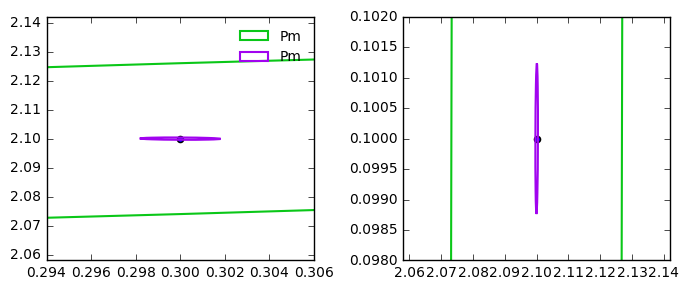

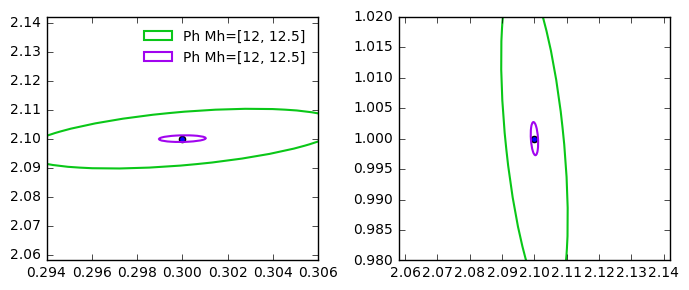

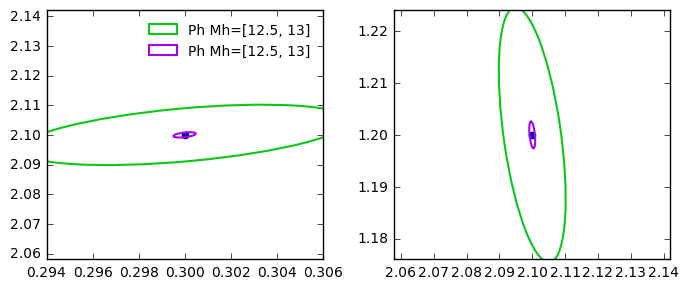

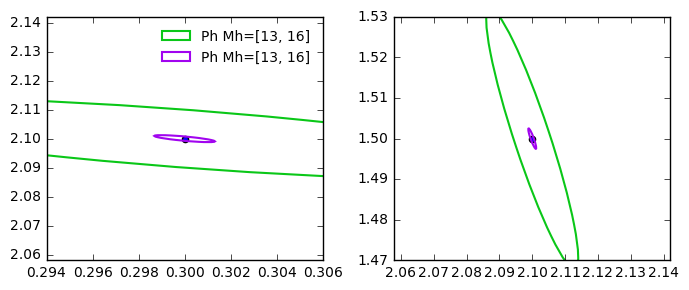

In [110]:
ix = 0.02

# plotEllipse(pos,P,edge,ls,ilabel,ax)
for i in range(len(Fisher_arr))[::2]:
    iF1 = Fisher_arr[i][0]
    iF2 = Fisher_arr[i+1][0]

    seed(34)
    ic1, ic2 = rand(3), rand(3)
    
    f, (ax1,ax2) = subplots(1,2,figsize=(7,3))
    p1,p2,p3=centers[i]
    ax1.scatter(p1,p2)
    ax2.scatter(p2,p3)

    plotEllipse([p1, p2], mat(iF1).I[[0,1],:][:,[0,1]], ic1,'solid',labels[i],ax1)
    plotEllipse([p1, p2], mat(iF2).I[[0,1],:][:,[0,1]], ic2,'solid',labels[i],ax1)
    plotEllipse([p2, p3], mat(iF1).I[[1,2],:][:,[1,2]], ic1,'solid',labels[i+1],ax2)
    plotEllipse([p2, p3], mat(iF2).I[[1,2],:][:,[1,2]], ic2,'solid',labels[i+1],ax2)
    ax1.set_xlim(p1*(1-ix), p1*(1+ix))
    ax1.set_ylim(p2*(1-ix), p2*(1+ix))
    ax2.set_xlim(p2*(1-ix), p2*(1+ix))
    ax2.set_ylim(p3*(1-ix), p3*(1+ix))
    ax1.legend(fontsize=10,frameon=0,loc=0)
    plt.tight_layout()
    show()